In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play audio files
import IPython.display as ipd
from IPython.display import Audio

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from pathlib import Path
import random
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import torch  
print ("Done")

Done


In [2]:
'''import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

print("Path to dataset files:", path)'''

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")\n\nprint("Path to dataset files:", path)'

In [3]:
Savee = './data/SAVEE/ALL/'

In [4]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
print(Savee_df.Emotions.value_counts())
Savee_df.head()

Emotions
neutral     120
angry        60
happy        60
fear         60
sad          60
disgust      60
surprise     60
Name: count, dtype: int64


,Emotions,Path
0,angry,./data/SAVEE/ALL/KL_a15.wav
1,neutral,./data/SAVEE/ALL/DC_n12.wav
2,happy,./data/SAVEE/ALL/JK_h09.wav
3,fear,./data/SAVEE/ALL/DC_f04.wav
4,happy,./data/SAVEE/ALL/DC_h01.wav


In [5]:
LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
LABELS = list(LABEL_DICT.values())

reverse_label_dict = {v: k for k, v in LABEL_DICT.items()}
Savee_df['Emotions'] = Savee_df['Emotions'].map(reverse_label_dict)

In [6]:
'''def get_max_audio_length():
    max_length = 0
    counter = 0
    fulltime =0
    for i in glob.glob(f'{Savee}/*.wav'):
        y, sr = librosa.load(i, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        fulltime +=duration
        if duration > max_length:
            max_length = duration
    
    return max_length

print(get_max_audio_length())'''

"def get_max_audio_length():\n    max_length = 0\n    counter = 0\n    fulltime =0\n    for i in glob.glob(f'{Savee}/*.wav'):\n        y, sr = librosa.load(i, sr=None)\n        duration = librosa.get_duration(y=y, sr=sr)\n        fulltime +=duration\n        if duration > max_length:\n            max_length = duration\n    \n    return max_length\n\nprint(get_max_audio_length())"

In [7]:
def get_log_melspec(data, sample_rate):
    """
    Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
    padded on both sides to ensure each clip is 5 seconds.
    Then the log mel spectrogram is extracted.
    """
    
    trimmed, _ = librosa.effects.trim(data, top_db=40)
    target_length = int(sample_rate * 7)

    if len(trimmed) < target_length:
        pad_length = target_length - len(trimmed)
        left_pad = pad_length // 2
        right_pad = pad_length - left_pad
        padded = np.pad(trimmed, (left_pad, right_pad), mode='constant')
    else:
        padded = trimmed[:target_length]
    mel = librosa.feature.melspectrogram(
        y=padded,
        sr=sample_rate,
        n_fft=1024,
        win_length=480,
        hop_length=512,
        n_mels=128
    )

    return librosa.power_to_db(mel, ref=np.max)

In [8]:

# extract features and save to dataframe
def load_melspec(row):
  a, sr = librosa.load(row['Path'], sr=24000)
  return get_log_melspec(a, sr) # Seham check here the silence_thresh, silence_thresh=55
Savee_df['logMel'] = Savee_df.apply(load_melspec, axis=1)

In [9]:
failed_files = Savee_df[Savee_df['logMel'].isnull()]
print(f"Number of failed files: {len(failed_files)}")

Number of failed files: 0


In [10]:
Savee_df.head()

,Emotions,Path,logMel
0,3,./data/SAVEE/ALL/KL_a15.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1,1,./data/SAVEE/ALL/DC_n12.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
2,2,./data/SAVEE/ALL/JK_h09.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
3,0,./data/SAVEE/ALL/DC_f04.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
4,2,./data/SAVEE/ALL/DC_h01.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [11]:
Savee_df.to_pickle('SAVEE_df.pkl')

In [12]:
# validate extracted features
for idx, row in Savee_df.iterrows():
  assert row.logMel.shape == (128, 329), f'shape: {row.logMel.shape}'

### Split the data

In [13]:

from sklearn.model_selection import train_test_split
X= Savee_df.iloc[:, 1:].values
Y = Savee_df['Emotions'].values
x_train_v, x_test, y_train_v, y_test = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((432, 2), (432,), (48, 2), (48,), (48, 2), (48,))

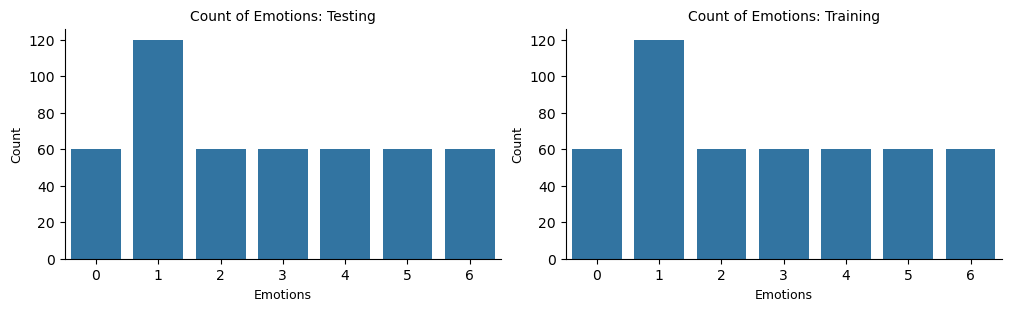

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True) 

# Plot for Testing Data
axes[0].set_title('Count of Emotions: Testing', size=10)
sns.countplot(x=Savee_df.Emotions, ax=axes[0])
axes[0].set_ylabel('Count', size=9)
axes[0].set_xlabel('Emotions', size=9)
sns.despine(ax=axes[0], top=True, right=True, left=False, bottom=False)

# Plot for Training Data
axes[1].set_title('Count of Emotions: Training', size=10)
sns.countplot(x=Savee_df.Emotions, ax=axes[1])
axes[1].set_ylabel('Count', size=9)
axes[1].set_xlabel('Emotions', size=9)
sns.despine(ax=axes[1], top=True, right=True, left=False, bottom=False)

plt.show()

In [15]:
audio_sample = Savee_df[Savee_df.Emotions == 4].sample(1, random_state=0).iloc[0]
audio_sample

Emotions                                                    4
Path                              ./data/SAVEE/ALL/JE_d10.wav
logMel      [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
Name: 156, dtype: object

In [16]:
Audio(audio_sample['Path'])

### DataLoader

In [17]:
class getdata(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (list of tuples): Each element is a tuple (file_path, spectrogram_array).
            labels (list): List of integer labels corresponding to the data.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the spectrogram and label
        _, spectrogram = self.data[idx]
        label = self.labels[idx]

        # Convert to torch tensor and add channel dimension
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        # Apply any transformation
        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

In [18]:
ds_train = getdata(x_train, y_train)
ds_test = getdata(x_test, y_test)
ds_val = getdata(x_val, y_val)

dl_train = DataLoader(ds_train, batch_size=2, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=2, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=True)

### Model

In [19]:
import math

def set_parameter_requires_grad(model, feature_extracting, trainable_layers):
    if feature_extracting:
        for name, param in model.named_parameters():
            print(name)
            if name not in trainable_layers:
                param.requires_grad = False

class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False) if in_ch != out_ch else None

        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut:
            identity = self.shortcut(identity)
        out += identity
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, class_num):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = ResNetBlock(32, 64, stride=1)
        self.layer2 = ResNetBlock(64, 128, stride=2)

        # Increased dropout rate
        self.dropout = nn.Dropout(0.50)
        self.fc = nn.Linear(128, class_num)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.layer1(x)
        x = self.layer2(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [20]:
def load_resnet18_audio():
  model = ResNet(len(LABELS))

  return model

In [21]:
def set_seed(seed):
    """
    Sets random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on a given dataloader.
    """
    model.eval()  # Set model to evaluation mode
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


def train_model(model, dl_train, dl_val, criterion, optimizer, scheduler, device, num_epochs=10, checkpoint_dir='checkpoint', save_best=True):
    """
    Trains the model with checkpointing and validation.
    """
    model.to(device)
    best_val_loss = float('inf')

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")

        # Training phase
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(dl_train, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimization step

            # Track training loss and accuracy
            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(dl_train)
        train_accuracy = correct_train / total_train

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, dl_val, criterion, device)

        # Step the learning rate scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Print epoch results
        print(f"\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"\tValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save best model
        if save_best and val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, 'best_model_savee.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss: {val_loss:.4f}")

    # Load the best model (if saved)
    if save_best:
        best_model_path = os.path.join(checkpoint_dir, 'best_model_savee.pth')
        model.load_state_dict(torch.load(best_model_path))

    return model, best_val_loss, val_accuracy


In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.0005

checkpoint_path = 'checkpoint/'

In [23]:
# Multi-run training and evaluation
n_runs = 3
n_epochs = 50
best_val_loss = float('inf')  # Initialize as infinity for comparison

checkpoint_dir = 'checkpoint/'
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure directory exists
checkpoint_path = os.path.join(checkpoint_dir, 'best_model_savee.pth')

# Loop through runs
for run in range(n_runs):
    run_seed = 42 + run  # Seed varies for each run
    set_seed(run_seed)  # Ensure reproducibility for each run

    print(f"Run {run+1}/{n_runs}")
    print("=" * 30)

    # Initialize model and optimizer
    model = load_resnet18_audio().to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=0.001,  # Regularization already in use
        amsgrad=True
    )

    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.4, patience=4, verbose=True
    )
    # Train and validate
    model, val_loss, val_acc = train_model(
        model, dl_train, dl_val, criterion, optimizer, scheduler, device, num_epochs=n_epochs
    )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"New best model found in Run {run+1} with validation loss: {val_loss:.4f}")
        torch.save(model.state_dict(), checkpoint_path)

    print()  # Blank line for better readability between runs

print("-" * 30)

Run 1/3
Epoch [1/50]


	Train Loss: 1.9225, Train Accuracy: 0.1991
	Validation Loss: 1.7412, Validation Accuracy: 0.4375
Best model saved with validation loss: 1.7412
Epoch [2/50]


	Train Loss: 1.8279, Train Accuracy: 0.3079
	Validation Loss: 1.5738, Validation Accuracy: 0.3958
Best model saved with validation loss: 1.5738
Epoch [3/50]


	Train Loss: 1.8121, Train Accuracy: 0.2917
	Validation Loss: 1.6582, Validation Accuracy: 0.3333
Epoch [4/50]


	Train Loss: 1.7500, Train Accuracy: 0.3032
	Validation Loss: 1.5028, Validation Accuracy: 0.4375
Best model saved with validation loss: 1.5028
Epoch [5/50]


	Train Loss: 1.7336, Train Accuracy: 0.3009
	Validation Loss: 2.7319, Validation Accuracy: 0.1250
Epoch [6/50]


	Train Loss: 1.7440, Train Accuracy: 0.3310
	Validation Loss: 1.7488, Validation Accuracy: 0.4167
Epoch [7/50]


	Train Loss: 1.6747, Train Accuracy: 0.3356
	Validation Loss: 1.4737, Validation Accuracy: 0.4375
Best model saved with validation loss: 1.4737
Epoch [8/50]


	Train Loss: 1.6313, Train Accuracy: 0.3588
	Validation Loss: 1.6526, Validation Accuracy: 0.1667
Epoch [9/50]


	Train Loss: 1.6231, Train Accuracy: 0.3657
	Validation Loss: 1.4004, Validation Accuracy: 0.4167
Best model saved with validation loss: 1.4004
Epoch [10/50]


	Train Loss: 1.5700, Train Accuracy: 0.3773
	Validation Loss: 1.3775, Validation Accuracy: 0.3958
Best model saved with validation loss: 1.3775
Epoch [11/50]


	Train Loss: 1.5722, Train Accuracy: 0.3403
	Validation Loss: 1.4084, Validation Accuracy: 0.4167
Epoch [12/50]


	Train Loss: 1.5152, Train Accuracy: 0.3958
	Validation Loss: 1.4854, Validation Accuracy: 0.4167
Epoch [13/50]


	Train Loss: 1.5021, Train Accuracy: 0.3472
	Validation Loss: 1.2890, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.2890
Epoch [14/50]


	Train Loss: 1.4452, Train Accuracy: 0.4329
	Validation Loss: 1.2532, Validation Accuracy: 0.5000
Best model saved with validation loss: 1.2532
Epoch [15/50]


	Train Loss: 1.4372, Train Accuracy: 0.4028
	Validation Loss: 6.4561, Validation Accuracy: 0.1250
Epoch [16/50]


	Train Loss: 1.4661, Train Accuracy: 0.3981
	Validation Loss: 2.6028, Validation Accuracy: 0.1458
Epoch [17/50]


	Train Loss: 1.4094, Train Accuracy: 0.4375
	Validation Loss: 1.2150, Validation Accuracy: 0.5833
Best model saved with validation loss: 1.2150
Epoch [18/50]


	Train Loss: 1.4122, Train Accuracy: 0.4144
	Validation Loss: 1.4037, Validation Accuracy: 0.4375
Epoch [19/50]


	Train Loss: 1.3755, Train Accuracy: 0.4398
	Validation Loss: 1.8162, Validation Accuracy: 0.2708
Epoch [20/50]


	Train Loss: 1.3388, Train Accuracy: 0.4630
	Validation Loss: 1.3054, Validation Accuracy: 0.4583
Epoch [21/50]


	Train Loss: 1.3553, Train Accuracy: 0.4444
	Validation Loss: 6.8331, Validation Accuracy: 0.1250
Epoch [22/50]


	Train Loss: 1.3591, Train Accuracy: 0.4398
	Validation Loss: 2.1742, Validation Accuracy: 0.1875
Epoch [23/50]


	Train Loss: 1.2787, Train Accuracy: 0.4606
	Validation Loss: 1.1355, Validation Accuracy: 0.5625
Best model saved with validation loss: 1.1355
Epoch [24/50]


	Train Loss: 1.2756, Train Accuracy: 0.4745
	Validation Loss: 1.1853, Validation Accuracy: 0.5625
Epoch [25/50]


	Train Loss: 1.2871, Train Accuracy: 0.4745
	Validation Loss: 1.1362, Validation Accuracy: 0.5417
Epoch [26/50]


	Train Loss: 1.2655, Train Accuracy: 0.5162
	Validation Loss: 1.6021, Validation Accuracy: 0.4583
Epoch [27/50]


	Train Loss: 1.2130, Train Accuracy: 0.5069
	Validation Loss: 1.1351, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.1351
Epoch [28/50]


	Train Loss: 1.2144, Train Accuracy: 0.4745
	Validation Loss: 2.1732, Validation Accuracy: 0.1667
Epoch [29/50]


	Train Loss: 1.2038, Train Accuracy: 0.4954
	Validation Loss: 1.0656, Validation Accuracy: 0.5625
Best model saved with validation loss: 1.0656
Epoch [30/50]


	Train Loss: 1.1787, Train Accuracy: 0.5231
	Validation Loss: 1.0742, Validation Accuracy: 0.5625
Epoch [31/50]


	Train Loss: 1.1862, Train Accuracy: 0.5301
	Validation Loss: 1.0869, Validation Accuracy: 0.5833
Epoch [32/50]


	Train Loss: 1.1616, Train Accuracy: 0.5069
	Validation Loss: 1.2578, Validation Accuracy: 0.4792
Epoch [33/50]


	Train Loss: 1.1619, Train Accuracy: 0.5301
	Validation Loss: 1.3427, Validation Accuracy: 0.3333
Epoch [34/50]


	Train Loss: 1.1628, Train Accuracy: 0.5301
	Validation Loss: 1.0694, Validation Accuracy: 0.5625
Epoch [35/50]


	Train Loss: 1.0819, Train Accuracy: 0.5787
	Validation Loss: 1.0745, Validation Accuracy: 0.5000
Epoch [36/50]


	Train Loss: 1.0951, Train Accuracy: 0.5718
	Validation Loss: 1.0835, Validation Accuracy: 0.5625
Epoch [37/50]


	Train Loss: 1.0855, Train Accuracy: 0.5694
	Validation Loss: 1.0786, Validation Accuracy: 0.5833
Epoch [38/50]


	Train Loss: 1.0741, Train Accuracy: 0.5856
	Validation Loss: 1.0549, Validation Accuracy: 0.6042
Best model saved with validation loss: 1.0549
Epoch [39/50]


	Train Loss: 1.0774, Train Accuracy: 0.5949
	Validation Loss: 1.1285, Validation Accuracy: 0.5417
Epoch [40/50]


	Train Loss: 1.0639, Train Accuracy: 0.5648
	Validation Loss: 1.0875, Validation Accuracy: 0.5833
Epoch [41/50]


	Train Loss: 1.0412, Train Accuracy: 0.5833
	Validation Loss: 1.0303, Validation Accuracy: 0.5833
Best model saved with validation loss: 1.0303
Epoch [42/50]


	Train Loss: 1.0647, Train Accuracy: 0.6134
	Validation Loss: 1.0352, Validation Accuracy: 0.6458
Epoch [43/50]


	Train Loss: 1.0437, Train Accuracy: 0.5602
	Validation Loss: 1.1378, Validation Accuracy: 0.6250
Epoch [44/50]


	Train Loss: 1.0506, Train Accuracy: 0.5648
	Validation Loss: 1.1015, Validation Accuracy: 0.5625
Epoch [45/50]


	Train Loss: 1.0042, Train Accuracy: 0.6042
	Validation Loss: 1.0489, Validation Accuracy: 0.5833
Epoch [46/50]


	Train Loss: 1.0146, Train Accuracy: 0.6019
	Validation Loss: 1.2215, Validation Accuracy: 0.4583
Epoch [47/50]


	Train Loss: 0.9975, Train Accuracy: 0.5995
	Validation Loss: 1.0707, Validation Accuracy: 0.6042
Epoch [48/50]


	Train Loss: 0.9866, Train Accuracy: 0.6250
	Validation Loss: 1.0697, Validation Accuracy: 0.6250
Epoch [49/50]


	Train Loss: 0.9630, Train Accuracy: 0.6204
	Validation Loss: 1.0740, Validation Accuracy: 0.5833
Epoch [50/50]


	Train Loss: 0.9579, Train Accuracy: 0.6644
	Validation Loss: 1.0495, Validation Accuracy: 0.6458
New best model found in Run 1 with validation loss: 1.0303

Run 2/3
Epoch [1/50]


	Train Loss: 1.9582, Train Accuracy: 0.2060
	Validation Loss: 1.8530, Validation Accuracy: 0.3542
Best model saved with validation loss: 1.8530
Epoch [2/50]


	Train Loss: 1.8737, Train Accuracy: 0.2616
	Validation Loss: 1.8324, Validation Accuracy: 0.3333
Best model saved with validation loss: 1.8324
Epoch [3/50]


	Train Loss: 1.8370, Train Accuracy: 0.2801
	Validation Loss: 1.5951, Validation Accuracy: 0.3750
Best model saved with validation loss: 1.5951
Epoch [4/50]


	Train Loss: 1.7996, Train Accuracy: 0.2963
	Validation Loss: 1.5470, Validation Accuracy: 0.3958
Best model saved with validation loss: 1.5470
Epoch [5/50]


	Train Loss: 1.7785, Train Accuracy: 0.2894
	Validation Loss: 1.6444, Validation Accuracy: 0.3333
Epoch [6/50]


	Train Loss: 1.7218, Train Accuracy: 0.2940
	Validation Loss: 1.5836, Validation Accuracy: 0.4167
Epoch [7/50]


	Train Loss: 1.7082, Train Accuracy: 0.3310
	Validation Loss: 1.4144, Validation Accuracy: 0.3750
Best model saved with validation loss: 1.4144
Epoch [8/50]


	Train Loss: 1.7343, Train Accuracy: 0.3102
	Validation Loss: 1.4495, Validation Accuracy: 0.3958
Epoch [9/50]


	Train Loss: 1.6655, Train Accuracy: 0.3380
	Validation Loss: 8.4220, Validation Accuracy: 0.0417
Epoch [10/50]


	Train Loss: 1.6868, Train Accuracy: 0.3125
	Validation Loss: 1.6975, Validation Accuracy: 0.2917
Epoch [11/50]


	Train Loss: 1.6068, Train Accuracy: 0.3310
	Validation Loss: 1.3732, Validation Accuracy: 0.4792
Best model saved with validation loss: 1.3732
Epoch [12/50]


	Train Loss: 1.5441, Train Accuracy: 0.3843
	Validation Loss: 1.4315, Validation Accuracy: 0.4792
Epoch [13/50]


	Train Loss: 1.5654, Train Accuracy: 0.3565
	Validation Loss: 1.3159, Validation Accuracy: 0.4583
Best model saved with validation loss: 1.3159
Epoch [14/50]


	Train Loss: 1.5086, Train Accuracy: 0.3750
	Validation Loss: 2.1400, Validation Accuracy: 0.1875
Epoch [15/50]


	Train Loss: 1.5077, Train Accuracy: 0.4074
	Validation Loss: 2.0226, Validation Accuracy: 0.3125
Epoch [16/50]


	Train Loss: 1.4670, Train Accuracy: 0.4259
	Validation Loss: 1.6725, Validation Accuracy: 0.4167
Epoch [17/50]


	Train Loss: 1.4384, Train Accuracy: 0.4468
	Validation Loss: 2.1235, Validation Accuracy: 0.4375
Epoch [18/50]


	Train Loss: 1.4063, Train Accuracy: 0.4329
	Validation Loss: 1.4219, Validation Accuracy: 0.4375
Epoch [19/50]


	Train Loss: 1.3496, Train Accuracy: 0.4838
	Validation Loss: 1.2977, Validation Accuracy: 0.6250
Best model saved with validation loss: 1.2977
Epoch [20/50]


	Train Loss: 1.3056, Train Accuracy: 0.4769
	Validation Loss: 1.1907, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.1907
Epoch [21/50]


	Train Loss: 1.3043, Train Accuracy: 0.4653
	Validation Loss: 1.2180, Validation Accuracy: 0.5208
Epoch [22/50]


	Train Loss: 1.3043, Train Accuracy: 0.4861
	Validation Loss: 2.2539, Validation Accuracy: 0.1875
Epoch [23/50]


	Train Loss: 1.3074, Train Accuracy: 0.5093
	Validation Loss: 1.1773, Validation Accuracy: 0.5000
Best model saved with validation loss: 1.1773
Epoch [24/50]


	Train Loss: 1.2954, Train Accuracy: 0.4884
	Validation Loss: 1.5124, Validation Accuracy: 0.2917
Epoch [25/50]


	Train Loss: 1.2744, Train Accuracy: 0.4907
	Validation Loss: 1.1644, Validation Accuracy: 0.4583
Best model saved with validation loss: 1.1644
Epoch [26/50]


	Train Loss: 1.2255, Train Accuracy: 0.5394
	Validation Loss: 1.3779, Validation Accuracy: 0.4792
Epoch [27/50]


	Train Loss: 1.2296, Train Accuracy: 0.5301
	Validation Loss: 1.1008, Validation Accuracy: 0.6042
Best model saved with validation loss: 1.1008
Epoch [28/50]


	Train Loss: 1.1914, Train Accuracy: 0.5394
	Validation Loss: 1.2786, Validation Accuracy: 0.5000
Epoch [29/50]


	Train Loss: 1.2315, Train Accuracy: 0.4954
	Validation Loss: 1.5318, Validation Accuracy: 0.3750
Epoch [30/50]


	Train Loss: 1.1550, Train Accuracy: 0.5394
	Validation Loss: 1.1510, Validation Accuracy: 0.5417
Epoch [31/50]


	Train Loss: 1.1929, Train Accuracy: 0.4977
	Validation Loss: 1.1581, Validation Accuracy: 0.5208
Epoch [32/50]


	Train Loss: 1.1939, Train Accuracy: 0.5324
	Validation Loss: 1.2084, Validation Accuracy: 0.5208
Epoch [33/50]


	Train Loss: 1.1352, Train Accuracy: 0.5532
	Validation Loss: 1.4700, Validation Accuracy: 0.3333
Epoch [34/50]


	Train Loss: 1.1227, Train Accuracy: 0.5532
	Validation Loss: 1.1060, Validation Accuracy: 0.5000
Epoch [35/50]


	Train Loss: 1.1164, Train Accuracy: 0.5347
	Validation Loss: 1.0955, Validation Accuracy: 0.6042
Best model saved with validation loss: 1.0955
Epoch [36/50]


	Train Loss: 1.1184, Train Accuracy: 0.5532
	Validation Loss: 1.1462, Validation Accuracy: 0.5000
Epoch [37/50]


	Train Loss: 1.0907, Train Accuracy: 0.5671
	Validation Loss: 1.1535, Validation Accuracy: 0.5000
Epoch [38/50]


	Train Loss: 1.0923, Train Accuracy: 0.5741
	Validation Loss: 1.0742, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.0742
Epoch [39/50]


	Train Loss: 1.1073, Train Accuracy: 0.5370
	Validation Loss: 1.1123, Validation Accuracy: 0.5417
Epoch [40/50]


	Train Loss: 1.0822, Train Accuracy: 0.5903
	Validation Loss: 1.0978, Validation Accuracy: 0.5833
Epoch [41/50]


	Train Loss: 1.0799, Train Accuracy: 0.5787
	Validation Loss: 1.0746, Validation Accuracy: 0.5417
Epoch [42/50]


	Train Loss: 1.0327, Train Accuracy: 0.6157
	Validation Loss: 1.0765, Validation Accuracy: 0.5208
Epoch [43/50]


	Train Loss: 1.0325, Train Accuracy: 0.5949
	Validation Loss: 1.0658, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.0658
Epoch [44/50]


	Train Loss: 1.0514, Train Accuracy: 0.5718
	Validation Loss: 3.5944, Validation Accuracy: 0.1875
Epoch [45/50]


	Train Loss: 1.0414, Train Accuracy: 0.6065
	Validation Loss: 1.0637, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.0637
Epoch [46/50]


	Train Loss: 1.0151, Train Accuracy: 0.6065
	Validation Loss: 2.0856, Validation Accuracy: 0.1667
Epoch [47/50]


	Train Loss: 1.0125, Train Accuracy: 0.6019
	Validation Loss: 2.9526, Validation Accuracy: 0.1875
Epoch [48/50]


	Train Loss: 1.0405, Train Accuracy: 0.5926
	Validation Loss: 1.0504, Validation Accuracy: 0.6042
Best model saved with validation loss: 1.0504
Epoch [49/50]


	Train Loss: 1.0281, Train Accuracy: 0.6042
	Validation Loss: 4.1501, Validation Accuracy: 0.1875
Epoch [50/50]


	Train Loss: 1.0181, Train Accuracy: 0.5810
	Validation Loss: 1.0712, Validation Accuracy: 0.5417

Run 3/3
Epoch [1/50]


	Train Loss: 1.9142, Train Accuracy: 0.2361
	Validation Loss: 1.7209, Validation Accuracy: 0.3750
Best model saved with validation loss: 1.7209
Epoch [2/50]


	Train Loss: 1.8639, Train Accuracy: 0.2824
	Validation Loss: 1.9388, Validation Accuracy: 0.1250
Epoch [3/50]


	Train Loss: 1.8094, Train Accuracy: 0.2870
	Validation Loss: 1.8285, Validation Accuracy: 0.3958
Epoch [4/50]


	Train Loss: 1.7707, Train Accuracy: 0.3102
	Validation Loss: 2.3765, Validation Accuracy: 0.1042
Epoch [5/50]


	Train Loss: 1.7230, Train Accuracy: 0.3287
	Validation Loss: 1.4693, Validation Accuracy: 0.4792
Best model saved with validation loss: 1.4693
Epoch [6/50]


	Train Loss: 1.6857, Train Accuracy: 0.3287
	Validation Loss: 1.4641, Validation Accuracy: 0.4583
Best model saved with validation loss: 1.4641
Epoch [7/50]


	Train Loss: 1.6932, Train Accuracy: 0.2986
	Validation Loss: 1.5099, Validation Accuracy: 0.3958
Epoch [8/50]


	Train Loss: 1.6449, Train Accuracy: 0.3403
	Validation Loss: 1.4721, Validation Accuracy: 0.4583
Epoch [9/50]


	Train Loss: 1.5639, Train Accuracy: 0.3750
	Validation Loss: 2.5962, Validation Accuracy: 0.1042
Epoch [10/50]


	Train Loss: 1.5205, Train Accuracy: 0.4097
	Validation Loss: 1.2962, Validation Accuracy: 0.5208
Best model saved with validation loss: 1.2962
Epoch [11/50]


	Train Loss: 1.4566, Train Accuracy: 0.4190
	Validation Loss: 3.6317, Validation Accuracy: 0.1042
Epoch [12/50]


	Train Loss: 1.4735, Train Accuracy: 0.3819
	Validation Loss: 1.2863, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.2863
Epoch [13/50]


	Train Loss: 1.4527, Train Accuracy: 0.4190
	Validation Loss: 1.2248, Validation Accuracy: 0.5000
Best model saved with validation loss: 1.2248
Epoch [14/50]


	Train Loss: 1.4400, Train Accuracy: 0.4514
	Validation Loss: 1.7607, Validation Accuracy: 0.3958
Epoch [15/50]


	Train Loss: 1.3874, Train Accuracy: 0.4097
	Validation Loss: 1.3345, Validation Accuracy: 0.4792
Epoch [16/50]


	Train Loss: 1.4015, Train Accuracy: 0.4167
	Validation Loss: 1.2675, Validation Accuracy: 0.4583
Epoch [17/50]


	Train Loss: 1.4173, Train Accuracy: 0.4144
	Validation Loss: 1.5912, Validation Accuracy: 0.4583
Epoch [18/50]


	Train Loss: 1.3396, Train Accuracy: 0.4421
	Validation Loss: 1.1915, Validation Accuracy: 0.5208
Best model saved with validation loss: 1.1915
Epoch [19/50]


	Train Loss: 1.3978, Train Accuracy: 0.4236
	Validation Loss: 1.2183, Validation Accuracy: 0.5000
Epoch [20/50]


	Train Loss: 1.3057, Train Accuracy: 0.4792
	Validation Loss: 1.5500, Validation Accuracy: 0.2083
Epoch [21/50]


	Train Loss: 1.3618, Train Accuracy: 0.4236
	Validation Loss: 1.2052, Validation Accuracy: 0.5625
Epoch [22/50]


	Train Loss: 1.3581, Train Accuracy: 0.4444
	Validation Loss: 1.1762, Validation Accuracy: 0.6042
Best model saved with validation loss: 1.1762
Epoch [23/50]


	Train Loss: 1.3179, Train Accuracy: 0.4861
	Validation Loss: 1.1603, Validation Accuracy: 0.5625
Best model saved with validation loss: 1.1603
Epoch [24/50]


	Train Loss: 1.3144, Train Accuracy: 0.4792
	Validation Loss: 1.0976, Validation Accuracy: 0.5833
Best model saved with validation loss: 1.0976
Epoch [25/50]


	Train Loss: 1.3267, Train Accuracy: 0.4375
	Validation Loss: 1.9398, Validation Accuracy: 0.3542
Epoch [26/50]


	Train Loss: 1.2701, Train Accuracy: 0.4699
	Validation Loss: 1.5966, Validation Accuracy: 0.5000
Epoch [27/50]


	Train Loss: 1.2825, Train Accuracy: 0.4722
	Validation Loss: 1.4845, Validation Accuracy: 0.2500
Epoch [28/50]


	Train Loss: 1.2929, Train Accuracy: 0.4769
	Validation Loss: 1.1802, Validation Accuracy: 0.5417
Epoch [29/50]


	Train Loss: 1.2785, Train Accuracy: 0.4699
	Validation Loss: 1.1551, Validation Accuracy: 0.5833
Epoch [30/50]


	Train Loss: 1.2040, Train Accuracy: 0.5023
	Validation Loss: 1.1190, Validation Accuracy: 0.6042
Epoch [31/50]


	Train Loss: 1.1880, Train Accuracy: 0.5301
	Validation Loss: 1.1134, Validation Accuracy: 0.5417
Epoch [32/50]


	Train Loss: 1.1659, Train Accuracy: 0.5093
	Validation Loss: 1.1236, Validation Accuracy: 0.5417
Epoch [33/50]


	Train Loss: 1.1598, Train Accuracy: 0.5440
	Validation Loss: 1.0953, Validation Accuracy: 0.6250
Best model saved with validation loss: 1.0953
Epoch [34/50]


	Train Loss: 1.1652, Train Accuracy: 0.5394
	Validation Loss: 1.1129, Validation Accuracy: 0.5417
Epoch [35/50]


	Train Loss: 1.1305, Train Accuracy: 0.5648
	Validation Loss: 1.0660, Validation Accuracy: 0.5417
Best model saved with validation loss: 1.0660
Epoch [36/50]


	Train Loss: 1.1293, Train Accuracy: 0.5579
	Validation Loss: 1.1348, Validation Accuracy: 0.5625
Epoch [37/50]


	Train Loss: 1.1144, Train Accuracy: 0.5787
	Validation Loss: 1.0726, Validation Accuracy: 0.5833
Epoch [38/50]


	Train Loss: 1.1463, Train Accuracy: 0.5440
	Validation Loss: 1.3225, Validation Accuracy: 0.2917
Epoch [39/50]


	Train Loss: 1.0724, Train Accuracy: 0.5903
	Validation Loss: 1.1372, Validation Accuracy: 0.4792
Epoch [40/50]


	Train Loss: 1.1035, Train Accuracy: 0.5903
	Validation Loss: 1.0510, Validation Accuracy: 0.6250
Best model saved with validation loss: 1.0510
Epoch [41/50]


	Train Loss: 1.0957, Train Accuracy: 0.5463
	Validation Loss: 1.1454, Validation Accuracy: 0.5417
Epoch [42/50]


	Train Loss: 1.0620, Train Accuracy: 0.5648
	Validation Loss: 1.0671, Validation Accuracy: 0.5625
Epoch [43/50]


	Train Loss: 1.0580, Train Accuracy: 0.5810
	Validation Loss: 1.2085, Validation Accuracy: 0.5417
Epoch [44/50]


	Train Loss: 1.0450, Train Accuracy: 0.5995
	Validation Loss: 2.3171, Validation Accuracy: 0.2708
Epoch [45/50]


	Train Loss: 1.0615, Train Accuracy: 0.5671
	Validation Loss: 1.0895, Validation Accuracy: 0.5833
Epoch [46/50]


	Train Loss: 1.0053, Train Accuracy: 0.5764
	Validation Loss: 1.0842, Validation Accuracy: 0.5625
Epoch [47/50]


	Train Loss: 1.0000, Train Accuracy: 0.5856
	Validation Loss: 1.0246, Validation Accuracy: 0.6667
Best model saved with validation loss: 1.0246
Epoch [48/50]


	Train Loss: 0.9937, Train Accuracy: 0.6019
	Validation Loss: 1.0435, Validation Accuracy: 0.6458
Epoch [49/50]


	Train Loss: 0.9984, Train Accuracy: 0.6296
	Validation Loss: 1.0475, Validation Accuracy: 0.6875
Epoch [50/50]


	Train Loss: 0.9800, Train Accuracy: 0.6134
	Validation Loss: 1.4313, Validation Accuracy: 0.3542
New best model found in Run 3 with validation loss: 1.0246

------------------------------


In [24]:
# Load the best model after all runs
print("Loading the best model for final evaluation...")
model = load_resnet18_audio()
try:
    print(checkpoint_path)
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)

    # Evaluate on validation data
    val_loss, val_acc = evaluate_model(model, dl_val, criterion, device=device)
    print(f"Training complete! Best Val Loss = {best_val_loss:.4f}, Best Val Accuracy = {val_acc:.4f}")
except FileNotFoundError:
    print("Error: Best model checkpoint not found. Ensure training was successful.")

Loading the best model for final evaluation...
checkpoint/best_model_savee.pth
Training complete! Best Val Loss = 1.0246, Best Val Accuracy = 0.6667


In [25]:
checkpoint_path

'checkpoint/best_model_savee.pth'

In [26]:
# To load the best model:
model = load_resnet18_audio()
model.load_state_dict(torch.load(checkpoint_path))
model.to('cuda')

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): ResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [27]:
train_loss, train_acc = evaluate_model(model, dl_train, criterion, device)
print(f"Test Loss = {train_loss:.4f}, train Accuracy = {train_acc:.4f}")

val_loss, val_acc = evaluate_model(model, dl_val, criterion, device)
print(f"Test Loss = {val_loss:.4f}, val Accuracy = {val_acc:.4f}")

test_loss, test_acc = evaluate_model(model, dl_test, criterion, device)
print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

Test Loss = 0.9024, train Accuracy = 0.6690
Test Loss = 1.0246, val Accuracy = 0.6667
Test Loss = 1.0246, Test Accuracy = 0.6667
